<a href="https://colab.research.google.com/github/ashwinidaya/Classify_ICDPointcloud_pointnet/blob/main/Classify_ICDPointcloud_pointnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

     |████████████████████████████████| 624kB 2.7MB/s 


In [ ]:
import os
import glob
import trimesh
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

In [ ]:

import pathlib
DATA_DIR = pathlib.Path('/content/drive/My Drive/Colab Notebooks/Point-Cloud-Classification-2-master/data/ICD_OFF/')

In [ ]:
# trimesh package to read and visualize the .off mesh files.
mesh = trimesh.load(os.path.join(DATA_DIR, "/content/drive/My Drive/Colab Notebooks/Point-Cloud-Classification-2-master/data/ICD_OFF/bharathantyam/train/b1.off"))
mesh.show()

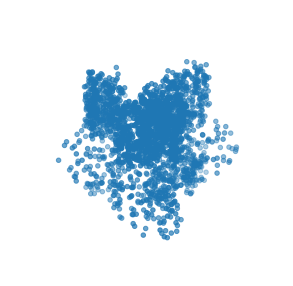

In [ ]:
#To convert a mesh file to a point cloud we first need to sample points on the mesh surface.
#sampled at 2048 locations and visualize in matplotlib.
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()


In [ ]:
#To generate pointcloud data need to parse through ICD dataset.Each and evry mesh is loaded and sampled into pointcloud and converted to numpy array and
# enumerator index value is stored as Object label.
def parse_dataset(num_points=2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [ ]:
#Set the number of points to be sampled and also set the batch size
NUM_POINTS = 2048
NUM_CLASSES = 5
BATCH_SIZE = 16

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(
    NUM_POINTS
)

processing class: odissi
processing class: kathak
processing class: yakshagana
processing class: bharathantyam
processing class: kathakali


In [ ]:
#ICD data is read by a tf.data.Dataset() object.
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

In [ ]:
#Build a model
#Each convolution and fully-connected layer (exception for end layers) consits of Convolution / Dense -> Batch Normalization -> ReLU Activation
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
#PointNet consists of two components. The primary MLP network, and the transformer net (T-net).
#The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice.
#The first time to transform the input features (n, 3) into a canonical representation. The second is an affine transformation for alignment in feature space (n, 3).
#As per the original paper we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


In [ ]:
def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
inputs = keras.Input(shape=(NUM_POINTS, 3))

x = tnet(inputs, 3)
x = conv_bn(x, 32)
x = conv_bn(x, 32)
x = tnet(x, 32)
x = conv_bn(x, 32)
x = conv_bn(x, 64)
x = conv_bn(x, 512)
x = layers.GlobalMaxPooling1D()(x)
x = dense_bn(x, 256)
x = layers.Dropout(0.3)(x)
x = dense_bn(x, 128)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet")
model.summary()


Model: "pointnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2048, 3)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2048, 32)     128         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2048, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2048, 32)     0           batch_normalization[0][0]        
___________________________________________________________________________________________

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
10/10 [==============================] - 2s 237ms/step - loss: 3.0861 - sparse_categorical_accuracy: 0.2483 - val_loss: 2260.8748 - val_sparse_categorical_accuracy: 0.2472
Epoch 2/20
10/10 [==============================] - 1s 129ms/step - loss: 2.7510 - sparse_categorical_accuracy: 0.3826 - val_loss: 14447.9619 - val_sparse_categorical_accuracy: 0.3483
Epoch 3/20
10/10 [==============================] - 1s 130ms/step - loss: 2.1644 - sparse_categorical_accuracy: 0.4094 - val_loss: 9.4063 - val_sparse_categorical_accuracy: 0.4607
Epoch 4/20
10/10 [==============================] - 1s 130ms/step - loss: 1.9729 - sparse_categorical_accuracy: 0.5168 - val_loss: 3199.2998 - val_sparse_categorical_accuracy: 0.1798
Epoch 5/20
10/10 [==============================] - 1s 128ms/step - loss: 1.9534 - sparse_categorical_accuracy: 0.4430 - val_loss: 28.0195 - val_sparse_categorical_accuracy: 0.2135
Epoch 6/20
10/10 [==============================] - 1s 130ms/step - loss: 1.9890 - sparse

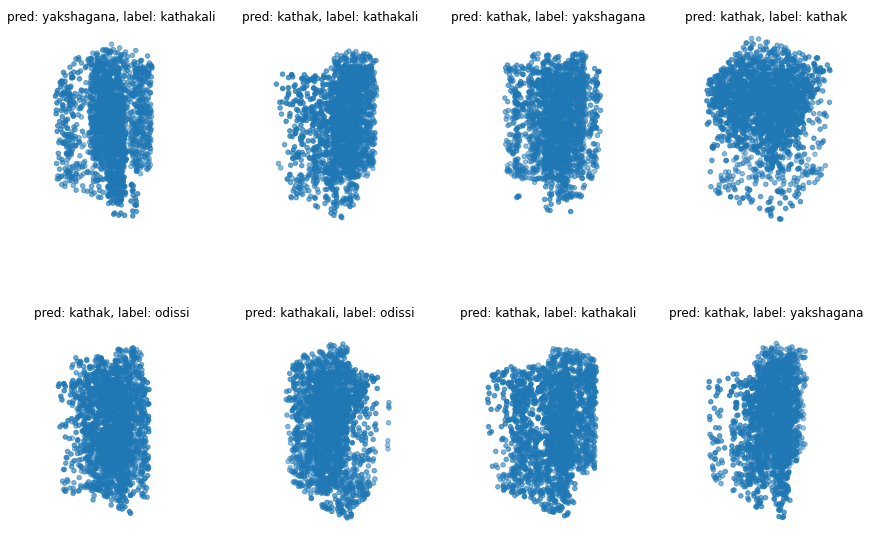

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=50, validation_data=test_dataset)

Epoch 1/50
10/10 [==============================] - 2s 205ms/step - loss: 1.9147 - sparse_categorical_accuracy: 0.5369 - val_loss: 5.8537 - val_sparse_categorical_accuracy: 0.5955
Epoch 2/50
10/10 [==============================] - 1s 130ms/step - loss: 1.5612 - sparse_categorical_accuracy: 0.5906 - val_loss: 22.8701 - val_sparse_categorical_accuracy: 0.5393
Epoch 3/50
10/10 [==============================] - 1s 129ms/step - loss: 1.7203 - sparse_categorical_accuracy: 0.5973 - val_loss: 3.0910 - val_sparse_categorical_accuracy: 0.5618
Epoch 4/50
10/10 [==============================] - 1s 128ms/step - loss: 1.6131 - sparse_categorical_accuracy: 0.6174 - val_loss: 2227.0979 - val_sparse_categorical_accuracy: 0.2247
Epoch 5/50
10/10 [==============================] - 1s 129ms/step - loss: 1.6173 - sparse_categorical_accuracy: 0.6107 - val_loss: 12.5054 - val_sparse_categorical_accuracy: 0.3820
Epoch 6/50
10/10 [==============================] - 1s 129ms/step - loss: 1.6312 - sparse_categ

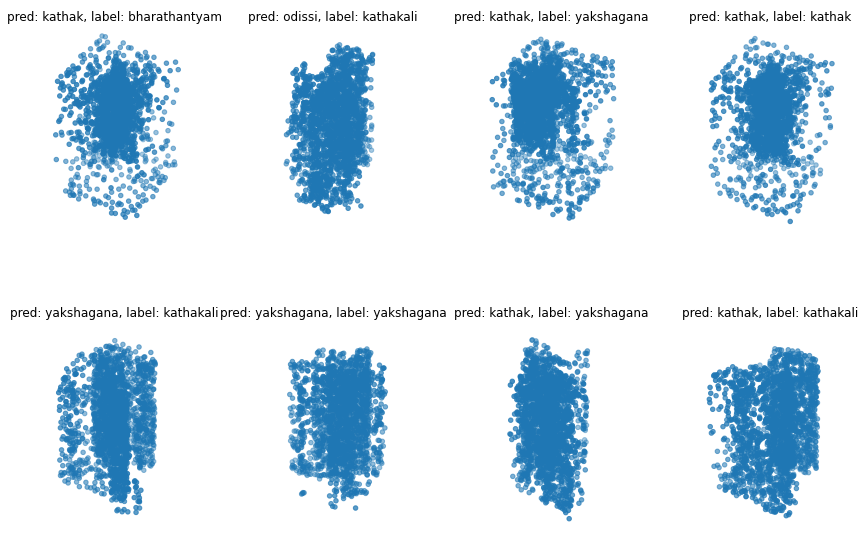

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
10/10 [==============================] - 2s 203ms/step - loss: 1.5031 - sparse_categorical_accuracy: 0.6644 - val_loss: 217.0093 - val_sparse_categorical_accuracy: 0.3820
Epoch 2/100
10/10 [==============================] - 1s 130ms/step - loss: 1.5177 - sparse_categorical_accuracy: 0.6779 - val_loss: 318.3001 - val_sparse_categorical_accuracy: 0.3258
Epoch 3/100
10/10 [==============================] - 1s 130ms/step - loss: 1.4435 - sparse_categorical_accuracy: 0.6913 - val_loss: 35.3536 - val_sparse_categorical_accuracy: 0.2472
Epoch 4/100
10/10 [==============================] - 1s 129ms/step - loss: 1.3550 - sparse_categorical_accuracy: 0.7181 - val_loss: 14.4959 - val_sparse_categorical_accuracy: 0.4831
Epoch 5/100
10/10 [==============================] - 1s 131ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.7785 - val_loss: 8.7926 - val_sparse_categorical_accuracy: 0.4157
Epoch 6/100
10/10 [==============================] - 1s 131ms/step - loss: 1.2057 - spars

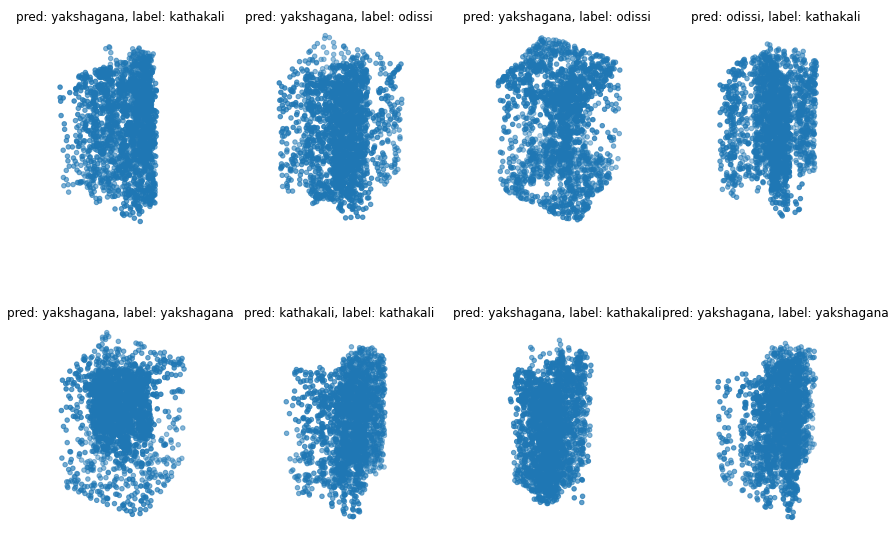

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=1000, validation_data=test_dataset)

Epoch 1/1000
10/10 [==============================] - 2s 228ms/step - loss: 1.0532 - sparse_categorical_accuracy: 0.8322 - val_loss: 6.6582 - val_sparse_categorical_accuracy: 0.4494
Epoch 2/1000
10/10 [==============================] - 1s 132ms/step - loss: 0.9696 - sparse_categorical_accuracy: 0.8591 - val_loss: 1.8424 - val_sparse_categorical_accuracy: 0.6854
Epoch 3/1000
10/10 [==============================] - 1s 132ms/step - loss: 1.0328 - sparse_categorical_accuracy: 0.8389 - val_loss: 4.8007 - val_sparse_categorical_accuracy: 0.4831
Epoch 4/1000
10/10 [==============================] - 1s 131ms/step - loss: 0.8700 - sparse_categorical_accuracy: 0.8993 - val_loss: 6.2104 - val_sparse_categorical_accuracy: 0.4607
Epoch 5/1000
10/10 [==============================] - 1s 132ms/step - loss: 0.9798 - sparse_categorical_accuracy: 0.8792 - val_loss: 28.5545 - val_sparse_categorical_accuracy: 0.4382
Epoch 6/1000
10/10 [==============================] - 1s 131ms/step - loss: 0.8151 - spar

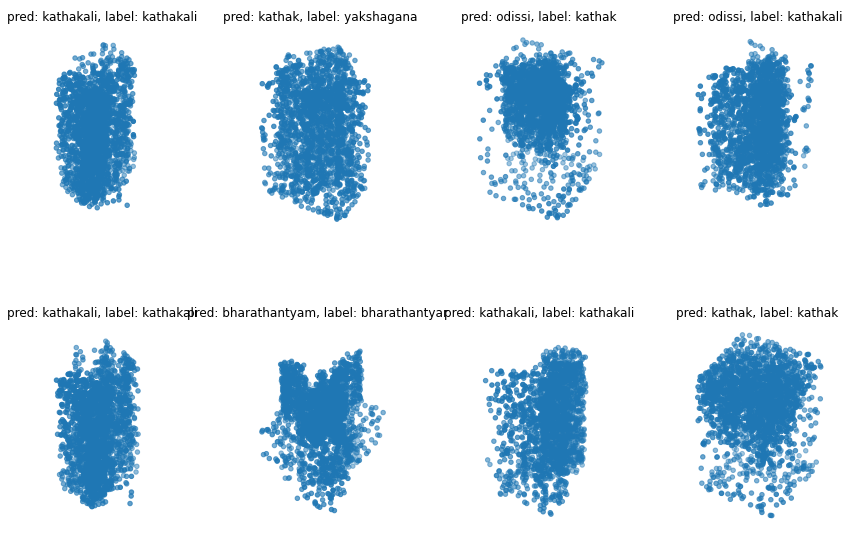

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()